# Group Analysis - FOOOFed EEG Analysis: Task
    
Applying FOOOF to task based EEG data, and comparing between young and old groups. 

In [426]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [427]:
from os.path import join as pjoin
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

import patsy
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import compare_cox, compare_j

from fooof.synth.gen import gen_aperiodic

In [428]:
# Import custom code for this analysis
%autoreload 2
from fio import *
from plts import *
from utils import *

# Settings

In [429]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'

# Set indices to separate groups
from settings import YNG_INDS, OLD_INDS

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

# Wether to save out plots or not
save_fig = False

print('Number of young subjects:  ', len(YNG_INDS))
print('Number of  old  subjects:  ', len(OLD_INDS))

Number of young subjects:   17
Number of  old  subjects:   14


In [430]:
# Data settings
srate = 512
tmin, tmax = -0.85, 1.1
times = np.arange(tmin, tmax, 1/srate)
seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]
n_subjs = 31

### Check dropped trials

In [431]:
# Load dropped trials & components
dropped_trials = np.load(pjoin(res_path, 'Group', 'dropped_trials.npy'))
dropped_components = np.load(pjoin(res_path, 'Group', 'dropped_components.npy'))

# Check dropped trials for each subject
print('SubNum \t\t # Dropped Trials \t # Dropped Components')
for ind, trials, components in zip(range(n_subjs), dropped_trials, dropped_components):
    temp_trials = trials[trials < 999.]
    temp_comps = components[components < 999.]
#    print(ind, '\t\t', len(temp_trials), '\t\t\t', len(temp_comps))

SubNum 		 # Dropped Trials 	 # Dropped Components


## Group FOOOFing - Trial Averaged Data

Notes:
- 3D data objects have the shape `[n_loads, n_subjs, n_times]`

### Load Data

In [537]:
# Load behavioural data
behav_dat = pd.read_csv(pjoin(res_path, 'Behav', 'neural_aging_data_behaviour.csv'))

In [562]:
# Convert data types
behav_dat['Age'] = behav_dat['Age'].astype('str')
behav_dat['Load'] = behav_dat['Load'].astype('str')

In [563]:
# Calculate average behaviour across loads
avg_behav = behav_dat.groupby('SubjID').mean()

In [564]:
# CHEATING
#for ind in [28, 59, 90]:
#    behav_dat.loc[ind, "d'"] = 2

In [565]:
# Load and extract FOOOF data
all_offsets, all_exps = load_fooof_task_ap(res_path, 'Contra')
all_alphas =  load_fooof_task_pe(res_path, 'Contra')
all_alphas_cf = load_fooof_task_pe(res_path, 'Contra', 0)
all_alphas_bw = load_fooof_task_pe(res_path, 'Contra', 2)

In [566]:
# Replace NaN with row mean
# import numpy.ma as ma
# out = []
# for mat in all_alphas:
#     mat = mat.T
#     out.append(np.where(np.isnan(mat), ma.array(mat, mask=np.isnan(mat)).mean(axis=0), mat).T)
# all_alphas = np.stack(out)

# Replace nan with global mean
#all_alphas[np.isnan(all_alphas)] = np.nanmean(all_alphas)

In [567]:
# Load canonical alpha analysis
canonical_group = np.load(pjoin(res_path, 'Group', 'canonical_group.npy'))

In [694]:
# Average across analytic alpha measures to get canonical alpha measure
seg_masks = []
for seg in seg_times:
    seg_masks.append(np.logical_and(times >= seg[0], times <= seg[1]))

canalpha = np.zeros_like(all_alphas)
for subi, subj_dat in enumerate(canonical_group):
    for lodi in range(3):
        for segi, mask in enumerate(seg_masks):
            canalpha[lodi, subi, segi] = np.mean(subj_dat[lodi, mask])

In [695]:
# Number of missing FOOOFed alphas
sum(sum(sum(np.isnan(all_alphas))))

10

In [696]:
# Drop missing FOOOF values from other measures
canalpha[np.isnan(all_alphas)] = np.nan
all_exps[np.isnan(all_alphas)] = np.nan
all_offsets[np.isnan(all_alphas)] = np.nan

In [697]:
# # TESTS
#all_alphas[:, 1, :] = np.nan
#canalpha [:, 1, :] = np.nan
# all_alphas[:, 8, :] = np.nan
# canalpha [:, 8, :] = np.nan

In [698]:
# CHEATING: DROP OUT SUBJECTS
#behav_dat[behav_dat['SubjID'] == 8] = np.nan
#behav_dat[behav_dat['SubjID'] == 1] = np.nan

## Check Behaviour & Trial EPhys Corrs - Baseline Measures

In [699]:
# Predict behaviour from 'absolute' FOOOF trial output measures
#   Note: as defined this model has three measures per subject, one for each load

# Settings
t_ind = 0

# Build the dataframe
df = pd.DataFrame()
df['exponent'] = all_exps[:, :, t_ind].flatten()

#df['alpha'] = all_alphas[:, :, t_ind].flatten()
df['alpha'] = canalpha[:, :, t_ind].flatten()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values

# Specify the model
#outcome, predictors = patsy.dmatrices("behav ~ exponent + alpha + age", df)
#outcome, predictors = patsy.dmatrices("behav ~ exponent * alpha * age", df)
outcome, predictors = patsy.dmatrices("behav ~ age + alpha + exponent + alpha:age + exponent:age", df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Check out the results
#print(res.summary())

In [700]:
# # Predict behaviour from 'absolute' FOOOF trial output measures, separately for each load

# # Settings
# t_ind = 2
# l_ind = 2

# # Build the dataframe
# df = pd.DataFrame()
# df['exponent'] = all_exps[l_ind, :, t_ind].flatten()
# df['alpha'] = all_alphas[l_ind, :, t_ind].flatten()

# df['behav'] = behav_dat[behav_dat['Load'] == l_ind+1]["d'"].values
# df['age'] = behav_dat[behav_dat['Load'] == l_ind+1]["Age"].values

# # Specift the model
# #outcome, predictors = patsy.dmatrices("behav ~ exponent + age", df)
# outcome, predictors = patsy.dmatrices("behav ~ exponent + alpha + age", df)
# #outcome, predictors = patsy.dmatrices("behav ~ exponent * alpha * age", df)
# #outcome, predictors = patsy.dmatrices("behav ~ age + alpha + exponent + alpha:age + exponent:age", df)
# mod = sm.OLS(outcome, predictors)
# res = mod.fit()

# # Check out the results
# #print(res.summary())

In [701]:
# # Predict from absolute FOOOF results, split up by group

# # Settings
# #group = 'young' # 'young', 'old'
# group = 'old' 
# t_ind = 2

# inds = YNG_INDS if group == 'young' else OLD_INDS
# age_gr = 1 if group == 'young' else 2

# # Build the dataframe
# df = pd.DataFrame()
# df['exponent'] = all_exps[:, inds, t_ind].flatten()

# df['alpha'] = all_alphas[:, inds, t_ind].flatten()
# #df['alpha'] = canalpha[:, inds, t_ind].flatten()

# df['behav'] = behav_dat[behav_dat.Age == age_gr]["d'"].values

# # 
# outcome, predictors = patsy.dmatrices("behav ~ exponent * alpha", df)
# mod = sm.OLS(outcome, predictors)
# res = mod.fit()

# # Check out the results
# print(res.summary())

In [702]:
# # Check relation between exponent and alpha
# print(pearsonr(df.exponent, df.alpha))
# #plt.plot(df.exponent, df.alpha, '.')

# print(pearsonr(df.behav, df.alpha))
# #plt.plot(df.behav, df.alpha, '.')

# print(pearsonr(df.behav, df.exponent))
# plt.plot(df.behav, df.exponent, '.')

## Difference Measures

Predict behaviour output from evoked responses of alpha and aperiodic. 

In [703]:
def reshape_dat(dat):
    
    yng_dat = np.vstack([dat[0, YNG_INDS, :], dat[1, YNG_INDS, :], dat[2, YNG_INDS, :]])
    old_dat = np.vstack([dat[0, OLD_INDS, :], dat[1, OLD_INDS, :], dat[2, OLD_INDS, :]])
    
    return yng_dat, old_dat

In [704]:
## ReOrg data - reshape 3D matrix, to 2D matrix with stacked trials

canal_st_yng, canal_st_old = reshape_dat(canalpha)

off_st_yng, off_st_old = reshape_dat(all_offsets)
exp_st_yng, exp_st_old = reshape_dat(all_exps)

al_st_yng, al_st_old = reshape_dat(all_alphas)
al_cf_st_yng, al_cf_st_old = reshape_dat(all_alphas_cf)
al_bw_st_yng, al_bw_st_old = reshape_dat(all_alphas_bw)

In [705]:
# Calculate difference measures
i1, i2 = 2, 0

canal_dif_yng = calc_diff(canal_st_yng, i1, i2)
canal_dif_old = calc_diff(canal_st_old, i1, i2)

off_dif_yng = calc_diff(off_st_yng, i1, i2)
off_dif_old = calc_diff(off_st_old, i1, i2)

exp_dif_yng = calc_diff(exp_st_yng, i1, i2)
exp_dif_old = calc_diff(exp_st_old, i1, i2)

al_dif_yng = calc_diff(al_st_yng, i1, i2)
al_dif_old = calc_diff(al_st_old, i1, i2)

al_cf_dif_yng = calc_diff(al_cf_st_yng, i1, i2)
al_cf_dif_old = calc_diff(al_cf_st_old, i1, i2)

al_bw_dif_yng = calc_diff(al_bw_st_yng, i1, i2)
al_bw_dif_old = calc_diff(al_bw_st_old, i1, i2)

In [706]:
print('CANALPHA - YNG: ', np.nanmean(canal_dif_yng))
print('CANALPHA - OLD: ', np.nanmean(canal_dif_old))

print('')
print('Alpha Power - YNG: ', np.nanmean(al_dif_yng))
print('Alpha Power - OLD: ', np.nanmean(al_dif_old))
print('')
print('Alpha CF - YNG: ', np.nanmean(al_cf_dif_yng))
print('Alpha CF - OLD: ', np.nanmean(al_cf_dif_old))
print('')
print('Alpha BW - YNG: ', np.nanmean(al_bw_dif_yng))
print('Alpha BW - OLD: ', np.nanmean(al_bw_dif_old))

print('')
print('Exp - YNG: ', np.nanmean(exp_dif_yng))
print('Exp - OLD: ', np.nanmean(exp_dif_old))
print('')
print('Off - YNG: ', np.nanmean(exp_dif_yng))
print('Off - OLD: ', np.nanmean(exp_dif_old))

CANALPHA - YNG:  1.7587073923825103e-07
CANALPHA - OLD:  -1.8642563800435488e-07

Alpha Power - YNG:  0.08159853781427646
Alpha Power - OLD:  -0.005133746231154371

Alpha CF - YNG:  -0.12449879811280581
Alpha CF - OLD:  0.6765393899310752

Alpha BW - YNG:  -0.29693609552241185
Alpha BW - OLD:  0.285449393734117

Exp - YNG:  -0.0480892733131357
Exp - OLD:  -0.05927353380939024

Off - YNG:  -0.0480892733131357
Off - OLD:  -0.05927353380939024


In [714]:
print_stat('CanAl', *nan_ttest(canal_dif_yng, canal_dif_old))

print('')
print_stat('Al-CF', *nan_ttest(al_cf_dif_yng, al_cf_dif_old))
print_stat('Al-PW', *nan_ttest(al_dif_yng, al_dif_old))
print_stat('Al-BW', *nan_ttest(al_bw_dif_yng, al_bw_dif_old))

print('')
print_stat('Exp', *nan_ttest(exp_dif_yng, exp_dif_old))
print_stat('Off', *nan_ttest(off_dif_yng, off_dif_old))

CanAl: 	  2.1291 	0.0361

Al-CF: 	 -3.8230 	0.0003
Al-PW: 	  2.7494 	0.0073
Al-BW: 	 -3.7894 	0.0003

Exp: 	  0.4920 	0.6240
Off: 	  1.4006 	0.1650


In [715]:
# Check correlations of difference measures with behaviour
print_stat('Sl-Yng', *nan_corr(exp_dif_yng, behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Sl-Old', *nan_corr(exp_dif_old, behav_dat[behav_dat.Age == '2']["d'"]))
print('')
print_stat('CanAl-Yng', *nan_corr(canal_dif_yng, behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('CanAl-Old', *nan_corr(canal_dif_old, behav_dat[behav_dat.Age == '2']["d'"]))
print('')
print_stat('Al-Yng', *nan_corr(al_dif_yng, behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Al-Old', *nan_corr(al_dif_old, behav_dat[behav_dat.Age == '2']["d'"]))
print('')
print_stat('Al-CF-Yng', *nan_corr(al_cf_dif_yng, behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Al-CF-Old', *nan_corr(al_cf_dif_old, behav_dat[behav_dat.Age == '2']["d'"]))
print('')
print_stat('Al-BW-Yng', *nan_corr(al_bw_dif_yng, behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Al-BW-Old', *nan_corr(al_bw_dif_old, behav_dat[behav_dat.Age == '2']["d'"]))

Sl-Yng: 	  0.3224 	0.0224
Sl-Old: 	 -0.2152 	0.2008

CanAl-Yng: 	 -0.2029 	0.1576
CanAl-Old: 	  0.2630 	0.1158

Al-Yng: 	 -0.1362 	0.3455
Al-Old: 	  0.3408 	0.0390

Al-CF-Yng: 	  0.1978 	0.1686
Al-CF-Old: 	  0.0086 	0.9598

Al-BW-Yng: 	  0.1042 	0.4714
Al-BW-Old: 	  0.0289 	0.8651


## Base Model: Age & Load

In [718]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values
 
outcome, predictors = patsy.dmatrices("behav ~ load + age", df)
mod_base = sm.OLS(outcome, predictors).fit()

print(mod_base.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     8.761
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           3.75e-05
Time:                        23:05:11   Log-Likelihood:                -118.31
No. Observations:                  93   AIC:                             244.6
Df Residuals:                      89   BIC:                             254.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0845      0.179     22.822      0.0

### CDA Model

In [719]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values
df['cda'] = behav_dat['CDA'].values
 
outcome, predictors = patsy.dmatrices("behav ~ load + cda + age", df)
mod_base = sm.OLS(outcome, predictors).fit()

print(mod_base.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.556
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           0.000115
Time:                        23:05:12   Log-Likelihood:                -118.21
No. Observations:                  93   AIC:                             246.4
Df Residuals:                      88   BIC:                             259.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1246      0.203     20.327      0.0

### Predicting from Canonical Alpha

In [720]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values

df['al_dif'] = np.concatenate([canal_dif_yng, canal_dif_old])
 
outcome, predictors = patsy.dmatrices("behav ~ load + al_dif * age", df)
mod_alpha_can = sm.OLS(outcome, predictors).fit()

print(mod_alpha_can.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     7.683
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           5.94e-06
Time:                        23:05:12   Log-Likelihood:                -106.24
No. Observations:                  87   AIC:                             224.5
Df Residuals:                      81   BIC:                             239.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.0165      0.177     

## Predicting from FOOOF: Alpha Power

In [721]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values

df['al_dif'] = np.concatenate([al_dif_yng, al_dif_old])
 
outcome, predictors = patsy.dmatrices("behav ~ load + al_dif * age", df)
mod_alpha_foo = sm.OLS(outcome, predictors).fit()

print(mod_alpha_foo.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7.993
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           3.66e-06
Time:                        23:05:12   Log-Likelihood:                -105.68
No. Observations:                  87   AIC:                             223.4
Df Residuals:                      81   BIC:                             238.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.0393      0.183     

## Predicting from FOOOF: All Alpha

In [722]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values

df['al_dif'] = np.concatenate([al_dif_yng, al_dif_old])
df['al_cf_dif'] = np.concatenate([al_cf_dif_yng, al_cf_dif_old])
df['al_bw_dif'] = np.concatenate([al_bw_dif_yng, al_bw_dif_old])

outcome, predictors = patsy.dmatrices("behav ~ load + al_cf_dif + al_bw_dif:age + al_dif * age", df)
mod_alpha_foo_all = sm.OLS(outcome, predictors).fit()

print(mod_alpha_foo_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     6.141
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           3.98e-06
Time:                        23:05:13   Log-Likelihood:                -101.87
No. Observations:                  87   AIC:                             221.7
Df Residuals:                      78   BIC:                             243.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9549      0.189  

In [723]:
print_stat('YNG:', *nan_corr(al_dif_yng, al_cf_dif_yng))
print_stat('OLD:', *nan_corr(al_dif_old, al_cf_dif_old))
print_stat('ALL:', *nan_corr(np.concatenate([al_dif_yng, al_dif_old]),
                             np.concatenate([al_cf_dif_yng, al_cf_dif_old])))

YNG:: 	 -0.2590 	0.0693
OLD:: 	  0.0501 	0.7684
ALL:: 	 -0.1673 	0.1214


(nan, 1.0)

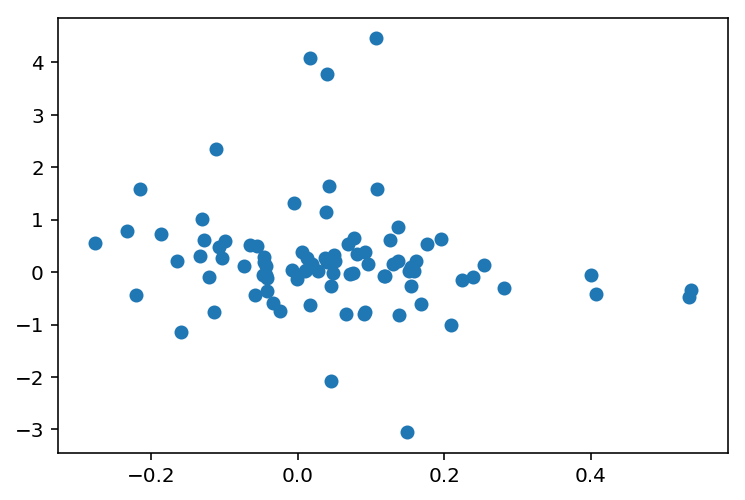

In [724]:
plt.scatter(np.concatenate([al_dif_yng, al_dif_old]), np.concatenate([al_cf_dif_yng, al_cf_dif_old]))
pearsonr(np.concatenate([al_dif_yng, al_dif_old]), np.concatenate([al_cf_dif_yng, al_cf_dif_old]))

## Predicting from FOOOF: Aperiodic

In [725]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values

df['exp_dif'] = np.concatenate([exp_dif_yng, exp_dif_old])
df['off_dif'] = np.concatenate([off_dif_yng, off_dif_old])

outcome, predictors = patsy.dmatrices("behav ~ load + age * exp_dif + off_dif:age", df)
mod_exponent_foo = sm.OLS(outcome, predictors).fit()

print(mod_exponent_foo.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     4.766
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           0.000166
Time:                        23:05:14   Log-Likelihood:                -107.80
No. Observations:                  87   AIC:                             231.6
Df Residuals:                      79   BIC:                             251.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1149      0.215  

### Predicting from FOOOF model with Alpha & Aperiodic

In [726]:
df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values
df['load'] = behav_dat['Load'].values

df['exp_dif'] = np.concatenate([exp_dif_yng, exp_dif_old])
df['al_dif'] = np.concatenate([al_dif_yng, al_dif_old])

outcome, predictors = patsy.dmatrices("behav ~ load + age * al_dif + exp_dif", df)
mod_all_foo = sm.OLS(outcome, predictors).fit()

print(mod_all_foo.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     6.733
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           8.45e-06
Time:                        23:05:16   Log-Likelihood:                -105.34
No. Observations:                  87   AIC:                             224.7
Df Residuals:                      80   BIC:                             241.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.0609      0.186     

## Model Comparisons

Explicitly test for differences between different model fits. 

#### Comparing Nested Models

Statsmodels offers three tests for nested models: f test, lagrange multiplier, likelihood ratio

Note that these three can be called from a results object, as `compare_x_test` with `f`, `lm` and `lr` as `x`. 

F-test can also be run with `anova_lm`. 

#### Comparing Non-Nested Models

Statmodels offers two tests for non-nested model: cox test & j test

They are better described in the R implementations:

- cox_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/coxtest.html
- j_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/jtest.html

In [727]:
# Compare nested models: alpha models vs base models
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Canonical alpha vs. Base Model')
    print(anova_lm(mod_base, mod_alpha_can))
    print('\n')
    print('FOOOFed alpha vs. Base Model')
    print(anova_lm(mod_base, mod_alpha_foo))

Canonical alpha vs. Base Model
   df_resid        ssr  df_diff    ss_diff        F    Pr(>F)
0      88.0  69.194025      0.0        NaN      NaN       NaN
1      81.0  58.573401      7.0  10.620624  2.09815  0.052908


FOOOFed alpha vs. Base Model
   df_resid        ssr  df_diff   ss_diff        F    Pr(>F)
0      88.0  69.194025      0.0       NaN      NaN       NaN
1      81.0  57.823785      7.0  11.37024  2.27536  0.036273


In [728]:
# Compare different alpha models
print('Canonical alpha vs. FOOOFed Alpha')
print_stat('Alpha-Model Compare', *compare_cox.run(mod_alpha_can, mod_alpha_foo))

Canonical alpha vs. FOOOFed Alpha
Alpha-Model Compare: 	 -1.3500 	0.1770


In [743]:
# Compare different alpha models
print('Canonical alpha vs. FOOOFed Alpha')
print_stat('Alpha-Model Compare', *compare_cox.run(mod_alpha_can, mod_alpha_foo_all))

Canonical alpha vs. FOOOFed Alpha
Alpha-Model Compare: 	 -4.3502 	0.0000


In [729]:
# Compare nested model: aperiodic exponent
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('FOOOF aperiodic vs. Base Model')
    print(anova_lm(mod_base, mod_exponent_foo))    

FOOOF aperiodic vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      88.0  69.194025      0.0       NaN       NaN       NaN
1      79.0  60.713667      9.0  8.480358  1.226062  0.291344


In [227]:
# Compare the full FOOOF model to the one with canonical alpha
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('FOOOF Full vs. Canonical Alpha')
    print(anova_lm(mod_alpha_can, mod_all_foo))

FOOOF Full vs. Canonical Alpha
   df_resid        ssr  df_diff   ss_diff        F    Pr(>F)
0      81.0  58.573401      0.0       NaN      NaN       NaN
1      80.0  57.377602      1.0  1.195799  1.66727  0.200343


In [228]:
# Compare FOOOF model with exponent to restricted model with just alpha (from FOOOF)
lm_val, p_val, df_diff = mod_all_foo.compare_f_test(mod_alpha_foo)
print_stat('Model comp', lm_val, p_val)

Model comp: 	  0.6221 	0.4326


## Correlations

????

In [273]:
# Generate the power @ alpha frequency given the aperiodic component, from the FOOOF fits
ap_alpha = []
for cf, off, exp in zip(all_alphas_cf.flatten(), all_offsets.flatten(), all_exps.flatten()):
    ap_alpha.append(gen_aperiodic(np.array([10]), [off, exp])[0])
ap_alpha = np.array(ap_alpha)

# Calculate the total power at 10 Hz (or about) from the 
foo_total = ap_alpha + all_alphas.flatten()

In [255]:
nan_inds = np.isnan(ap_alpha)

In [232]:
# Calculate correlation between canonical and FOOOF alpha
print_stat('', *pearsonr(np.array(canalpha.flatten())[~nan_inds], np.array(all_alphas.flatten())[~nan_inds]))

: 	  0.3310 	0.0000


In [233]:
# Calculate correlation between canonical alpha and aperiodic component @ 10 Hz
print_stat('', *pearsonr(np.array(canalpha.flatten())[~nan_inds], np.array(ww)[~nan_inds]))

: 	  0.0271 	0.6586


In [234]:
# Calculate correlation between the canonical alpha and the FOOOF model total @ 10 Hz
print_stat('',*pearsonr(np.array(canalpha.flatten())[~nan_inds], np.array(foo_total.flatten())[~nan_inds]))

: 	  0.2331 	0.0001


In [181]:
# Check correlation between exponent & d', and alpha & d' - for a specific load and time point

# Set which load and time point to use
l_ind = 0
t_ind = 0

print_stat("Sl-Lo-d'", *pearsonr(all_exps[l_ind, :, t_ind],
                                 behav_dat[behav_dat.Load == str(l_ind + 1)]["d'"]))
print_stat("Al-Lo-d'", *pearsonr(all_alphas[l_ind, :, t_ind],
                                 behav_dat[behav_dat.Load == str(l_ind + 1)]["d'"]))

Sl-Lo-d': 	   nan 	1.0000
Al-Lo-d': 	   nan 	1.0000


In [37]:
t_ind = 2

print_stat("Sl-d'", *pearsonr(all_exps[:, :, t_ind].flatten(), behav_dat["d'"].values))
print_stat("Al-d'", *pearsonr(all_alphas[:, :, t_ind].flatten(), behav_dat["d'"].values))

Sl-d': 	   nan 	1.0000
Al-d': 	   nan 	1.0000


In [38]:
# Average d' with average measures
t_ind = 2
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_exps[:, :, t_ind], 0)))
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_alphas[:, :, t_ind], 0)))

XX: 	   nan 	1.0000
XX: 	   nan 	1.0000


In [39]:
# Average d' with average measures: diff measures
t_ind = 2
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_exps[:, :, 2] - all_exps[:, :, 0], 0)))
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_alphas[:, :, 2] - all_alphas[:, :, 0], 0)))

XX: 	   nan 	1.0000
XX: 	   nan 	1.0000


In [40]:
ind = 2

print_stat('Yng-Sl', *pearsonr(exp_st_yng[:, ind], behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Old-Sl', *pearsonr(exp_st_old[:, ind], behav_dat[behav_dat.Age == '2']["d'"]))

print('')

print_stat('Yng-Al', *pearsonr(al_st_yng[:, ind], behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Old-Al', *pearsonr(al_st_old[:, ind], behav_dat[behav_dat.Age == '2']["d'"]))

print('')

print_stat('Yng-CanAl', *pearsonr(canal_st_yng[:, ind], behav_dat[behav_dat.Age == '1']["d'"]))
print_stat('Old-CanAl', *pearsonr(canal_st_old[:, ind], behav_dat[behav_dat.Age == '2']["d'"]))

Yng-Sl: 	   nan 	1.0000
Old-Sl: 	   nan 	1.0000

Yng-Al: 	   nan 	1.0000
Old-Al: 	   nan 	1.0000

Yng-CanAl: 	   nan 	1.0000
Old-CanAl: 	   nan 	1.0000


In [41]:
# Average across loads
sl_resps = np.diff(np.mean(all_exps, 0))
al_resps = np.diff(np.mean(all_alphas, 0))

# # Take specific load
# load_ind = 2
# sl_resps = all_exps[load_ind, :, :]
# al_resps = all_alphas[load_ind, :, :]

In [42]:
# Correlations between reactivity measures
print_stat('SLR & ALR - 1', *pearsonr(sl_resps[:, 0], al_resps[:, 0]))
print_stat('SLR & ALR - 2', *pearsonr(sl_resps[:, 1], al_resps[:, 1]))

SLR & ALR - 1: 	   nan 	1.0000
SLR & ALR - 2: 	   nan 	1.0000


In [43]:
# ind = 0
# edat = sl_resps

# print_stat('\tALL', *pearsonr(avg_behav["d'"], al_resps[:, 0]))
# print_stat('\tYNG', *pearsonr(avg_behav[avg_behav['Age'] == '1']["d'"], edat[YNG_INDS, ind]))
# print_stat('\tOLD', *pearsonr(avg_behav[avg_behav['Age'] == '2']["d'"], edat[OLD_INDS, ind]))

In [44]:
# edat = sl_resps

# print_stat('\tALL', *pearsonr(avg_behav["d'"], al_resps[:, 0]))
# print_stat('\tYNG', *pearsonr(avg_behav[avg_behav['Age'] == 1]["d'"], np.mean(edat[YNG_INDS], 1)))
# print_stat('\tOLD', *pearsonr(avg_behav[avg_behav['Age'] == 2]["d'"], np.mean(edat[OLD_INDS], 1)))

In [45]:
print(pearsonr(avg_behav["CDA"], al_resps[:, 0]))
print(pearsonr(avg_behav["CDA"], sl_resps[:, 0]))

(nan, 1.0)
(nan, 1.0)


In [46]:
print(pearsonr(exp_dif_yng, al_dif_yng))
print(pearsonr(exp_dif_old, al_dif_old))

(nan, 1.0)
(nan, 1.0)


## Miscellaneous Crap

In [47]:
# # Build the dataframe

# t_ind = 2
# l_ind = 0 

# df = pd.DataFrame()

# df['behav'] = behav_dat[behav_dat['Load'] == l_ind+1]["d'"].values
# df['age'] = behav_dat[behav_dat['Load'] == l_ind+1]["Age"].values

# df['exp_dif'] = np.concatenate([exp_dif_yng, exp_dif_old])
# df['al_dif'] = np.concatenate([al_dif_yng, al_dif_old])

# # 
# outcome, predictors = patsy.dmatrices("behav ~ exp_dif + al_dif + age", df)
# #outcome, predictors = patsy.dmatrices("behav ~ age * exp_dif", df)
# mod = sm.OLS(outcome, predictors)
# res = mod.fit()

# # Check out the results
# print(res.summary())

In [48]:
#
al_ = np.mean(all_exps[:, YNG_INDS, :], 0)

exp_st_yng = np.vstack([all_exps[0, YNG_INDS, :], all_exps[1, YNG_INDS, :], all_exps[2, YNG_INDS, :]])
exp_st_old = np.vstack([all_exps[0, OLD_INDS, :], all_exps[1, OLD_INDS, :], all_exps[2, OLD_INDS, :]])

#
al_st_yng = np.vstack([all_alphas[0, YNG_INDS, :], all_alphas[1, YNG_INDS, :], all_alphas[2, YNG_INDS, :]])
al_st_old = np.vstack([all_alphas[0, OLD_INDS, :], all_alphas[1, OLD_INDS, :], all_alphas[2, OLD_INDS, :]])

In [49]:
# Get the change in behavioural scores between highes & lowest loads
delta_behavs = []
temp_df = behav_dat[behav_dat.Age == 1]
for subj_id in set(temp_df.SubjID.values):
    temp = behav_dat[behav_dat.SubjID == subj_id]
    delta_behavs.append(temp[temp.Load == 3]["d'"].values[0] - temp[temp.Load == 1]["d'"].values[0])
delta_behavs = np.array(delta_behavs)

In [50]:
#behav_dat.Age == 2

In [51]:
# Get the change in physiological scores between highes & lowest loads
temp_dat = all_exps
temp = temp_dat[2, :, :] - temp_dat[0, :, :]
temp[np.isnan(temp)] = 0
delta_phys = temp[:, 2] - temp[:, 0]

In [52]:
#print('ALL:', pearsonr(delta_behavs, delta_phys[OLD_INDS]))
#plt.scatter(delta_behavs, delta_phys[OLD_INDS])

In [53]:
#print('ALL:', pearsonr(delta_behavs, delta_phys[YNG_INDS]))
#plt.scatter(delta_behavs, delta_phys[YNG_INDS])

In [54]:
# plt.scatter(delta_behavs[OLD_INDS], delta_phys[OLD_INDS], label='OLD')
# print('OLD:', pearsonr(delta_behavs[OLD_INDS], delta_phys[OLD_INDS]))
# plt.scatter(delta_behavs[YNG_INDS], delta_phys[YNG_INDS], label='YNG')
# print('YNG:', pearsonr(delta_behavs[YNG_INDS], delta_phys[YNG_INDS]))
# plt.legend()
# plt.xlabel('Delta Behav');
# plt.ylabel('Delta Physiology');

In [55]:
#cur_dat = canalpha
#cur_dat = all_exps
cur_dat = all_alphas

# Get phys-responsiveness, as late minus pre
temp = cur_dat[:, :, 2] - cur_dat[:, :, 1]
# Or - just take late
#temp = cur_dat[:, :, 2]

# Replace any nans as zeros
temp[np.isnan(temp)] = 0

# Get delta physiology as high load minus low load
delta_phys = temp[2, :] - temp[0, :]

In [56]:
# print('ALL:', pearsonr(delta_behavs, delta_phys))
# print('OLD:', pearsonr(delta_behavs[OLD_INDS], delta_phys[OLD_INDS]))
# print('YNG:', pearsonr(delta_behavs[YNG_INDS], delta_phys[YNG_INDS]))

# plt.scatter(delta_behavs[OLD_INDS], delta_phys[OLD_INDS], label='OLD')
# plt.scatter(delta_behavs[YNG_INDS], delta_phys[YNG_INDS], label='YNG')

# #plt.ylim([-0.0000005, 0.0000005])

# plt.legend()
# plt.xlabel('Delta Behav');
# plt.ylabel('Delta Physiology');

In [57]:
# Check for missing data
for si, dd in zip(range(31), sum(np.isnan(all_alphas), 0).sum(1)):
    print(si, '\t', dd)

0 	 0
1 	 5
2 	 0
3 	 1
4 	 0
5 	 0
6 	 0
7 	 0
8 	 3
9 	 0
10 	 0
11 	 0
12 	 0
13 	 0
14 	 0
15 	 0
16 	 0
17 	 0
18 	 0
19 	 0
20 	 0
21 	 0
22 	 0
23 	 0
24 	 0
25 	 0
26 	 0
27 	 0
28 	 0
29 	 1
30 	 0


# Predict canonalpha from FOOOF alpha + chi

1) Canonical Alpha vs. FOOOF alpha

2) Canonical Alpha vs. Chi

3) Canonical Alpha cs. FOOOF alpha + chi

In [58]:
from sklearn import preprocessing

In [59]:
can_scaled = preprocessing.scale(canalpha.flatten())
alf_scaled = preprocessing.scale(all_alphas.flatten())
exp_scaled = preprocessing.scale(all_exps.flatten())

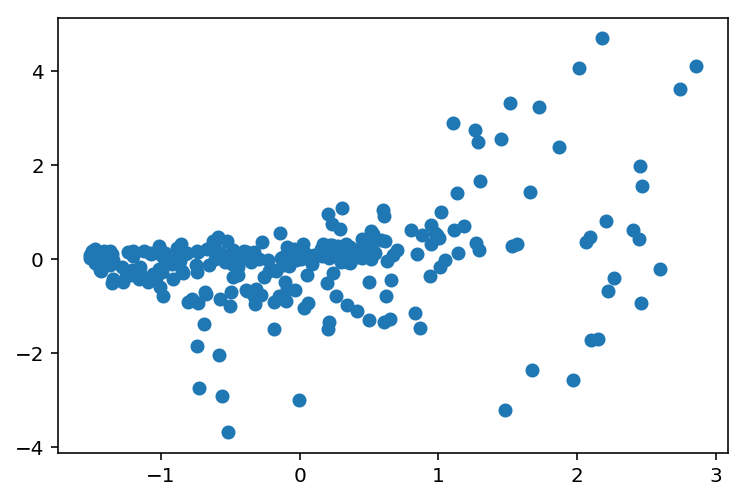

In [60]:
plt.scatter(alf_scaled, can_scaled)

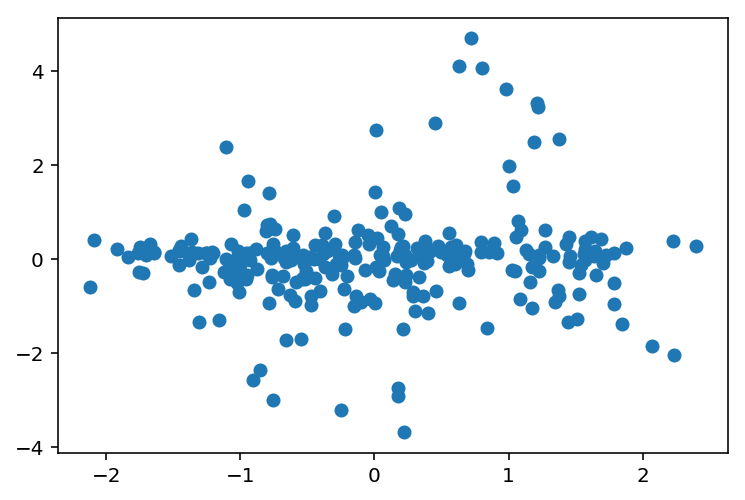

In [61]:
plt.scatter(exp_scaled, can_scaled)

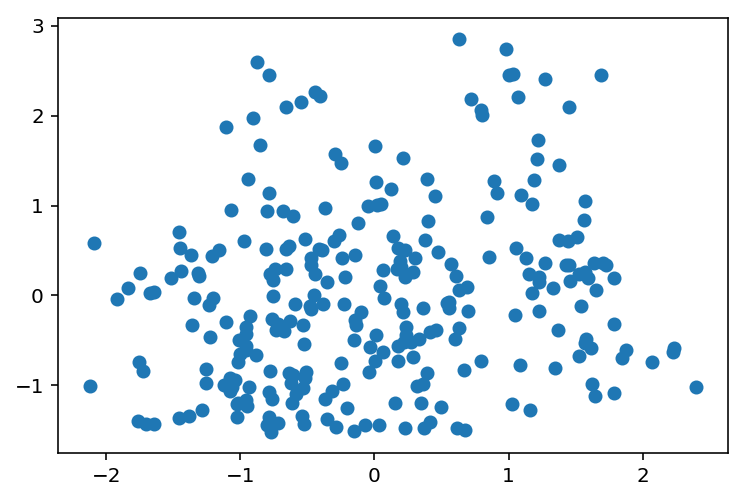

In [62]:
plt.scatter(exp_scaled, alf_scaled)

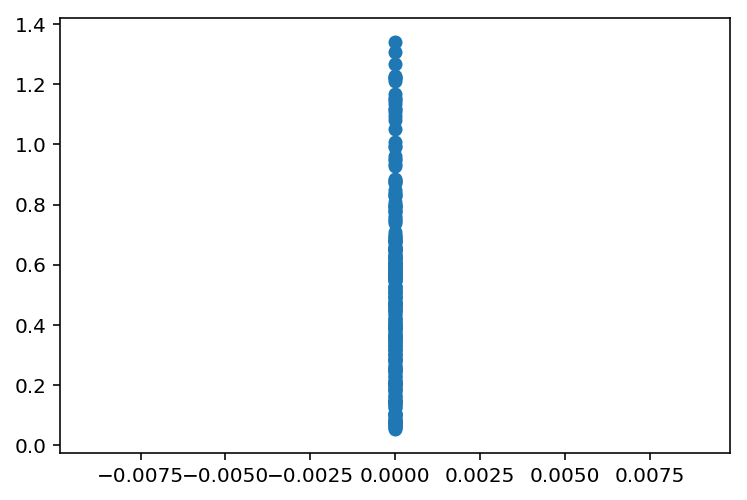

In [63]:
plt.scatter(canalpha.flatten(), all_alphas.flatten())
#plt.xlim([canalpha.flatten().min(), canalpha.flatten().max()]);

In [64]:
len(alf_scaled)

279

In [65]:
len(exp_scaled)

279

In [66]:
# Build the dataframe
df = pd.DataFrame()

df['exp'] = np.concatenate([exp_dif_yng, exp_dif_old])
df['fal'] = np.concatenate([al_dif_yng, al_dif_old])
df['canal'] = np.concatenate([canal_dif_yng, canal_dif_old])
#df['exp'] = all_exps[:, :, 1].flatten()
#df['fal'] = all_alphas[:, :, 1].flatten()
#df['canal'] = canalpha[:, :, 1].flatten()

outcome, predictors = patsy.dmatrices("canal ~ fal * exp", df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Check out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  canal   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     104.3
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           4.55e-28
Time:                        20:58:10   Log-Likelihood:                 1166.3
No. Observations:                  87   AIC:                            -2325.
Df Residuals:                      83   BIC:                            -2315.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.806e-07   4.57e-08     -3.952      0.0

In [67]:
outcome.min()

array(-1.80554058e-06)

In [68]:
plt.scatter(qq, outcome)
plt.xlim([outcome.min(), outcome.max()])
plt.ylim([outcome.min(), outcome.max()])

NameError: name 'qq' is not defined

In [ ]:
plt.scatter(qq, outcome)
plt.xlim([outcome.min(), outcome.max()])
plt.ylim([outcome.min(), outcome.max()])

In [ ]:
qq = res.predict(predictors)

In [ ]:
res.params

In [ ]:
df['fal'].values

In [ ]:
df.corr('spearman')

In [ ]:
pd.plotting.scatter_matrix(df);

In [ ]:
df.corr?

In [ ]:
all_alphas

In [ ]:
gen_aperiodic(np.array([10, 11]), [1, 1])

In [ ]:
gen_aperiodic?

In [745]:
from statsmodels.stats.diagnostic import CompareCox, compare_cox, CompareJ, compare_j



In [748]:
compare_cox.__doc__ = CompareCox.run.__doc__

In [749]:
compare_cox?

In [747]:
print(CompareCox.run.__doc__)

run Cox test for non-nested models

        Parameters
        ----------
        results_x : Result instance
            result instance of first model
        results_z : Result instance
            result instance of second model
        attach : bool
            If true, then the intermediate results are attached to the instance.

        Returns
        -------
        tstat : float
            t statistic for the test that including the fitted values of the
            first model in the second model has no effect.
        pvalue : float
            two-sided pvalue for the t statistic

        Notes
        -----
        Tests of non-nested hypothesis might not provide unambiguous answers.
        The test should be performed in both directions and it is possible
        that both or neither test rejects. see ??? for more information.

        References
        ----------
        ???

        
